# Import packages & functions

In [29]:
%reset
%cd /Users/yuyuan/Desktop/Work/CMDM_Lab/COVID19_Proj_toGitHub
import numpy as np
import re
import matplotlib.pyplot as plt
from StructuralAnalysisTools.mdPLOTtools import moving_avg
from scipy.optimize import curve_fit, minimize, leastsq
import pandas as pd
from scipy.integrate import quad

/Users/yuyuan/Desktop/Work/CMDM_Lab/COVID19_Proj_toGitHub


## Define function for xvg file reading

In [30]:
def readxvg(wkdir_list, variants_name, do_moving_avg, avg_window = 100):
    x_list, y_list, header_list = [], [], []
    x_list_all, y_list_all = [], []
    for wkdir, eachname in zip(wkdir_list, variants_name):
        x, y, header= [], [], []
        with open(f"{wkdir}/hbac.xvg") as f:
            for line in f:
                cols = line.split()
                m = re.search('\d+', cols[0])
                if not m == None:
                    x.append(float(cols[0]))
                    y.append(float(cols[2]))
                else:
                    header.append(cols)
        if do_moving_avg:
            y = moving_avg(y, avg_window)
            x_shift = int(avg_window/2)
            x = x[ 0+x_shift : len(y)+x_shift ]
        x_list.append(x[0:1000] + x[1000:5000:10] ) 
        y_list.append(y[0:1000] + y[1000:5000:10] )
        x_list_all.append(x)
        y_list_all.append(y)
        header_list.append(header)
    
    data = {
            "x_list":x_list,
            "y_list":y_list,
            "header_list":header_list,
            "x_list_all":x_list_all,
            "y_list_all":y_list_all,
            "variants_name":variants_name
        }
    return data

# Read xvg

In [31]:
# Omicron
variants_name = ['WT', 'omicron_BA.1', 'omicron_BA.2', 'omicron_BA.2.12.1', 'omicron_BA.4_5']
colorlist = ['#adadad', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# previous VOCs
# variants_name = ['WT', 'alpha', 'beta', 'gamma', 'delta']
# colorlist = ['#adadad', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# VOIs
# variants_name = ['WT', 'deltaplus',  'epsilon', 'lambda', 'mu-R346K', 'mu']
# colorlist = ['#adadad', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#b54e77']

#### parameters (7a91) ####
gmx_results_folderpath = 'Data/rawdata/md_results/variants_7a91'
wkdir_list = [f'{gmx_results_folderpath}/{eachname}' for eachname in variants_name]
do_moving_avg = False
avg_window = 100
#####################
pdb_7a91 = readxvg(wkdir_list, variants_name, do_moving_avg, avg_window)

#### parameters (6m0j) ####
gmx_results_folderpath = 'Data/rawdata/md_results/variants_6m0j'
wkdir_list = [f'{gmx_results_folderpath}/{eachname}' for eachname in variants_name]
do_moving_avg = False
avg_window = 100
#####################
pdb_6m0j = readxvg(wkdir_list, variants_name, do_moving_avg, avg_window)

#### parameters (groud truth) ####
parent_path = 'Data/rawdata/md_results/'
gmx_results_folderpath = ['variants_6m0j', 'variants_7a91', 'variants_7mjn', 'variants_7v80', 'variants_7v84', 'variants_7v8b']
gmx_results_folderpath = [parent_path + '/' + each for each in gmx_results_folderpath]
variants_name = ['WT', 'WT','alpha', 'beta', 'gamma', 'delta']

wkdir_list = [f'{eachpath}/{eachname}' for eachpath, eachname in zip(gmx_results_folderpath,variants_name)]
do_moving_avg = False
avg_window = 100
#####################
pdb_groundtruth = readxvg(wkdir_list, variants_name, do_moving_avg, avg_window)

# Fitting method 1 (easy but not good)

## Read data

In [32]:
# read data
x_list = pdb_7a91["x_list"]
y_list = pdb_7a91["y_list"]
x_list_all = pdb_7a91["x_list_all"]
y_list_all = pdb_7a91["y_list_all"]
variants_name = pdb_7a91["variants_name"]

## Fitting

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


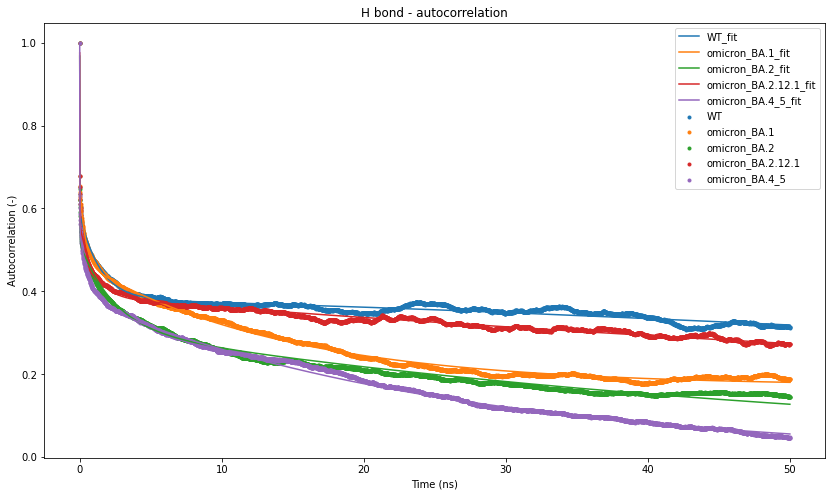

In [33]:

# def func(t, A1, tau1, tau2):
    # return A1 * np.exp(-t/tau1) + (1-A1) * np.exp(-t/tau2) 
def func(t, A1, A2, A3, tau1, tau2, tau3):
   return A1 * np.exp(-t/tau1) + A2 * np.exp(-t/tau2) + A3 * np.exp(-t/tau3)
#def func(t, A1, A2, A3, A4, tau1, tau2, tau3, tau4):
#    return A1 * np.exp(-t/tau1) + A2 * np.exp(-t/tau2) + A3 * np.exp(-t/tau3) + A4 * np.exp(-t/tau4) 

paras = []
fig = plt.figure(figsize=[14,8])
ax1 = fig.add_subplot(111)
ax1.set_title("H bond - autocorrelation")    
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Autocorrelation (-)')
ax1.ticklabel_format(axis="y")
err_residue_list = []
def diff(y, y_pred):
    return sum((y-y_pred) ** 2)
for index, eachname in enumerate(variants_name):
    x = x_list[index]
    y = y_list[index]
    popt, pcov = curve_fit(func, x, y, maxfev=50000)
    paras.append(popt)
    x_all = x_list_all[index]
    y_all = y_list_all[index]
    y_pred = func(np.array(x_all), *popt)
    ax1.scatter(x_all, y_all, label=eachname, marker='.')
    ax1.plot(x_all, y_pred, label=f'{eachname}_fit')
    err = diff(y_all, y_pred)
    err_residue_list.append(err)
leg = ax1.legend()
# plt.yscale("log")
plt.show()

## Fitting parameters and error

In [34]:
df = pd.DataFrame(paras)
df.index = variants_name
df.columns = ['A1', 'A2', 'A3','tau1', 'tau2', 'tau3']
# df.columns = ['A1', 'A2', 'A3', 'tau1', 'tau2', 'tau3', 'tau4']
df['err_residue'] = err_residue_list
df['sum_A'] = df['A1']+df['A2']+df['A3']
df

,A1,A2,A3,tau1,tau2,tau3,err_residue,sum_A
WT,-6.763354,0.206670,7.144216,8.380662e+01,1.425155,87.833241,0.565507,0.587532
omicron_BA.1,0.171547,0.299240,0.194769,2.602808e+08,14.255657,0.362948,0.413711,0.665556
omicron_BA.2,0.451757,0.204541,0.311355,1.390573e-02,2.415735,56.063761,0.531879,0.967653
omicron_BA.2.12.1,0.414721,0.173722,0.386924,1.304930e-02,1.002028,144.834469,0.197237,0.975367
omicron_BA.4_5,0.382146,0.158911,0.454077,2.602903e+01,0.693107,0.007633,0.202816,0.995134


# Fitting method 2 (good but need to assign initial value)

## fitting : CLASS object

In [35]:
class hbac_fitting:
    def __init__(self, dataset, variants_name):
        paras = []
        x_list_all = dataset["x_list_all"]
        y_list_all = dataset["y_list_all"]
        y_list_pred = []
        err_residue_list = []

        for index, _ in enumerate(variants_name):
            x_all = np.array(x_list_all[index])
            y_all = np.array(y_list_all[index])
            popt, pcov = leastsq(func=self.residuals, x0=(0.1, 0.33, 0.55, 0.5, 95., 0.01), args=(x_all,y_all))
            paras.append(popt)
            y_pred = self.func(x_all, *popt)
            err = self.diff(y_all, y_pred)
            err_residue_list.append(err)
            y_list_pred.append(y_pred)

        dataset['err_residue_list'] = err_residue_list
        dataset['paras'] = paras
        dataset['y_list_pred'] = y_list_pred
        self.dataset = dataset
    
    def func(self, t, A1, A2, A3, tau1, tau2, tau3):
        return A1 * np.exp(-t/tau1) + A2 * np.exp(-t/tau2) + A3 * np.exp(-t/tau3)
    
    def residuals(self, p, x, y):
        sum_A = p[0] + p[1] + p[2]
        penalty = abs(sum_A - 1)
        y_pred = self.func(x, p[0], p[1], p[2], p[3], p[4], p[5])
        return (y-y_pred) ** 2  + penalty

    def diff(self, y, y_pred):
        return sum((y-y_pred) ** 2)

## fit & plot

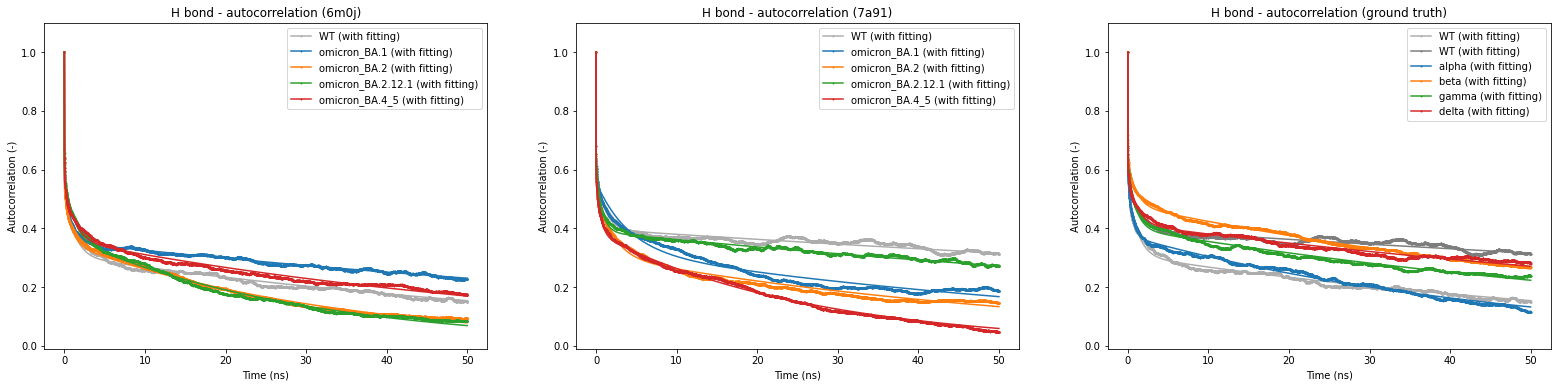

In [36]:
# Omicron
variants_name = ['WT', 'omicron_BA.1', 'omicron_BA.2', 'omicron_BA.2.12.1', 'omicron_BA.4_5']
colorlist = ['#adadad', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# previous VOCs
# variants_name = ['WT', 'alpha', 'beta', 'gamma', 'delta']
# colorlist = ['#adadad', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# VOIs
# variants_name = ['WT', 'deltaplus',  'epsilon', 'lambda', 'mu-R346K', 'mu']
# colorlist = ['#adadad', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#b54e77']

# layout setting 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[27,6])

# 6m0j -read
pdb_6m0j = hbac_fitting(pdb_6m0j, variants_name).dataset
# 6m0j -plot
ax1.set_title("H bond - autocorrelation (6m0j)")    
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Autocorrelation (-)')
ax1.ticklabel_format(axis="y")
for index, eachname in enumerate(variants_name):
    x_all = pdb_6m0j["x_list_all"][index]
    y_all = pdb_6m0j["y_list_all"][index]
    y_pred = pdb_6m0j["y_list_pred"][index]
    ax1.plot(x_all, y_all, label=f'{eachname} (with fitting)', marker = '.',
              markersize = 2, color = colorlist[index])
    ax1.plot(x_all, y_pred, label = '__no_label__', color = colorlist[index]) # label=f'{eachname}_fit'
ax1.legend()
ax1.set_ylim([-0.01, 1.1])


# 7a91 -read
pdb_7a91 = hbac_fitting(pdb_7a91, variants_name).dataset
# 7a91 -plot
ax2.set_title("H bond - autocorrelation (7a91)")    
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Autocorrelation (-)')
ax2.ticklabel_format(axis="y")
for index, eachname in enumerate(variants_name):
    x_all = pdb_7a91["x_list_all"][index]
    y_all = pdb_7a91["y_list_all"][index]
    y_pred = pdb_7a91["y_list_pred"][index]
    ax2.plot(x_all, y_all, label=f'{eachname} (with fitting)', marker = '.',
              markersize = 2, color = colorlist[index])
    ax2.plot(x_all, y_pred, label = '__no_label__', color = colorlist[index]) # label=f'{eachname}_fit'
ax2.legend()
ax2.set_ylim([-0.01, 1.1])


# ground truth -read
variants_name = ['WT', 'WT','alpha', 'beta', 'gamma', 'delta']
colorlist = ['#adadad', '#7d7d7d', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
pdb_groundtruth = hbac_fitting(pdb_groundtruth, variants_name).dataset
# ground truth -plot
ax3.set_title("H bond - autocorrelation (ground truth)")    
ax3.set_xlabel('Time (ns)')
ax3.set_ylabel('Autocorrelation (-)')
ax3.ticklabel_format(axis="y")
for index, eachname in enumerate(variants_name):
    x_all = pdb_groundtruth["x_list_all"][index]
    y_all = pdb_groundtruth["y_list_all"][index]
    y_pred = pdb_groundtruth["y_list_pred"][index]
    ax3.plot(x_all, y_all, label=f'{eachname} (with fitting)', marker = '.',
              markersize = 2, color = colorlist[index])
    ax3.plot(x_all, y_pred, label = '__no_label__', color = colorlist[index]) # label=f'{eachname}_fit'
ax3.legend()
ax3.set_ylim([-0.01, 1.1])

plt.show()

## summary of fitting parameters and error

In [37]:
# define summary table function
def summary_table(data, variants_name):
    df = pd.DataFrame(data['paras'])
    df.index = variants_name
    df.columns = ['A1', 'A2', 'A3','tau1', 'tau2', 'tau3']
    df['err_residue'] = data["err_residue_list"]
    df['sum_A'] = df['A1']+df['A2']+df['A3']
    return df


# choose which to summary
variants_name = ['WT', 'omicron_BA.1', 'omicron_BA.2', 'omicron_BA.2.12.1', 'omicron_BA.4_5'] # Omicron
# variants_name = ['WT', 'alpha', 'beta', 'gamma', 'delta'] # previous VOCs
# variants_name = ['WT', 'deltaplus',  'epsilon', 'lambda', 'mu-R346K', 'mu'] # VOIs
summary_table(pdb_7a91, variants_name)


## groudtruth ##
# variants_name = ['WT', 'WT', 'alpha', 'beta', 'gamma', 'delta']
# summary_table(pdb_groundtruth, variants_name)


,A1,A2,A3,tau1,tau2,tau3,err_residue,sum_A
WT,0.203036,0.397553,0.399411,1.027289,216.417449,0.007684,0.526796,1.0
omicron_BA.1,0.230343,0.326891,0.442766,3.955023,74.715895,0.011033,1.315198,1.0
omicron_BA.2,0.244334,0.308385,0.447281,1.894568,59.725922,0.008377,0.654707,1.0
omicron_BA.2.12.1,0.209437,0.387991,0.402572,0.728844,140.950030,0.007878,0.229538,1.0
omicron_BA.4_5,0.181169,0.382102,0.436729,0.556214,26.800315,0.006550,0.196769,1.0


## save csv (if wanted)

In [38]:
#df.to_csv('~/Desktop/df.csv')

## tau_rlx and tau_HB

In [39]:
paras = pdb_6m0j['paras'] # can switch to pdb_groundtruth, pdb_7a91 or pdb_6m0j or groundtruth
variants_name = ['WT', 'omicron_BA.1', 'omicron_BA.2', 'omicron_BA.2.12.1', 'omicron_BA.4_5'] # Omicron
# variants_name = ['WT', 'alpha', 'beta', 'gamma', 'delta'] # previous VOCs
# variants_name = ['WT', 'deltaplus',  'epsilon', 'lambda', 'mu-R346K', 'mu'] # VOIs

# variants_name for ground truth
if not len(variants_name) == len(paras):
    variants_name = ['WT', 'WT', 'alpha', 'beta', 'gamma', 'delta'] 

# define functions
def func(t, A1, A2, A3, tau1, tau2, tau3): # fitting function
    return A1 * np.exp(-t/tau1) + A2 * np.exp(-t/tau2) + A3 * np.exp(-t/tau3)
def diff(t, yt): # error calculator
    y_func = func(t, *paras[index])
    return (y_func - yt) ** 2

# tau HB summary
tau_HB = []
for index, eachname in enumerate(variants_name):
    value_ = quad(func, 0, np.inf, args=tuple(paras[index]))[0]
    # print(f"tau_HB({eachname}): {value_}")
    tau_HB.append(value_)

# tau rlx summary
tau_rlx = []
for index, eachname in enumerate(variants_name):
    res = minimize( diff, 1, args=1/np.exp(1) ,method='Nelder-Mead', tol=1e-8 )
    # print(f'tau_rlx({eachname}): {res.x[0]}')
    tau_rlx.append(res.x[0])

# dataframe output
df = pd.DataFrame()
df['tau_HB'] = tau_HB
df['tau_rlx'] = tau_rlx
df.index = variants_name
df

,tau_HB,tau_rlx
WT,22.493137,1.515671
omicron_BA.1,41.253766,1.808986
omicron_BA.2,11.869585,1.431033
omicron_BA.2.12.1,11.302841,2.447308
omicron_BA.4_5,24.125146,2.749407
